# Prueba del algoritmo Watershed

Probaré el algoritmo Watershed para el procesamiento de imagenes. Guía de la prueba e información relevante en:
- https://opencv-python-tutroals.readthedocs.io/en/latest/py_tutorials/py_imgproc/py_watershed/py_watershed.html
- https://www.pyimagesearch.com/2015/11/02/watershed-opencv/
- http://www.cmm.mines-paristech.fr/~beucher/wtshed.html

Se trata de aplicar un algoritmo watershed basado en marcado, porque utilizar un algoritmo watershed unicamente sobre el threeshold puede incurrir en imprecisiones al haber ruido y otras irregularidades en la imagen, por eso lo que se hace en esta versión del algoritmo es definir lo que conocemos seguro que es el fondo (background) y marcarlo de un color, definir lo que conocemos seguro que es el primer plano (foreground) y marcarlo de otro color diferente, y la región que no estamos seguros (unknown) se etiquetará con 0 y será la diferencia de lo que sabemos seguro que es background y lo que sabemos seguro que es foreground. A ese marcador descirto le aplicaremos el algoritmo watershed, el marcador se irá acrualizando con los marcadores que se eligieron para el background y foreground y las fronteras se etiquetarán con -1.

Lo pruebo con uno de los ejemplos más básicos, que se trata de monedas distribuidas sobre una superficie homogenea, por lo que hay mucho contraste entre el background y el foreground, además en este ejemplo básico no habrá elementos superpuestos, el objetivo es detectar y contar las monedas que serán el primer plano de la imagen.

Cargo la imagen original y aproximo una estimación de los objetos aplicando una conversión a escala de grises a dicha imagen y a continuación aplico el threshold de Otsu para obtener una imagen que solo tenga dos clases: background y foreground.

**Nota**: se puede ver que se suma al threshold de Otsu un coeficiente de inversión del threshold binario, esto se usa, debido a que el método de Otsu no clasifica como background al fondo y como foreground al objeto. Lo que hace es clasificar como background a los colores más oscuros y como foreground a los más claros, por eso si el objeto es más oscuro que el background se le debe añadir ese factor de inversión binario.

In [1]:
import numpy as np
import cv2
from matplotlib import pyplot as plt
# Cargo la imagen de las monedas que se va ha procesar
img = cv2.imread('watershed_coins_01.png')
#shifted = cv2.pyrMeanShiftFiltering(img, 21, 51)
gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
ret, thresh = cv2.threshold(gray, 0, 255, cv2.THRESH_BINARY_INV + cv2.THRESH_OTSU)

Muestro imagenes relevantes.

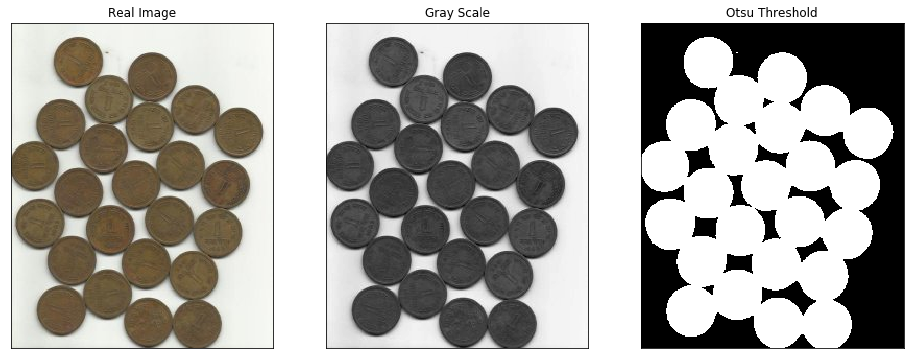

In [2]:
fig = plt.figure(figsize=(16, 10))
fig.add_subplot(1,3,1)
plt.imshow(img[...,::-1])  # RGB-> BGR
plt.title("Real Image")
plt.xticks([]), plt.yticks([])

fig.add_subplot(1,3,2)
plt.imshow(gray, "gray")
plt.title("Gray Scale")
plt.xticks([]), plt.yticks([])

fig.add_subplot(1,3,3)
plt.imshow(thresh, "gray")
plt.title("Otsu Threshold")
plt.xticks([]), plt.yticks([])

plt.show()

Otra manera de mostrar las imagenes usando el método `imshow` de OpenCV:

Para el notebook usaré los métodos de ploteo proporcionados por matplotlib, para mostrarlo de una manera más explicativa dado que el método de OpenCV los abre en una ventana nueva.

In [3]:
# cv2.imshow("Input", img) # Abre una ventana
# cv2.waitKey(0) # Espera una señal (pulsar boton cerrar ventana), para que no ejecute la siguiente instrucción inmediatamente.
# cv2.destroyAllWindows() # Destruye el proceso de la ventana.

In [4]:
# cv2.imshow("Thresh", thresh)
# cv2.waitKey(0)
# cv2.destroyAllWindows()

Una vez tengo el threshold hay que tratar de eliminar cualquier ruido blanco de la imagen, para esto puedo usar morphological opening. El problema queda en que no se está seguro sobre la región de los límites entre background y foreground.

Para definir por seguro lo que es el background, se usan métodos de dilatación lo que elimará los límites de la zona foreground y la expandirá hacía la background haciendo que me pueda asegurar de que la región de background resultante es realmente background. 

Por otra parte para definir lo que es seguro que es el foreground podría usar un método de erosión que contrae los límites y entonces la región restante de foreground podría decir por seguro que se trata de un objeto (foreground), en este caso moneda, pero tiene un problema, que los objetos se están tocando, por lo que no funcionará. Lo muestro en imagenes para entenderlo mejor.

In [5]:
# noise removal
kernel = np.ones((3, 3), np.uint8)
opening = cv2.morphologyEx(thresh, cv2.MORPH_OPEN, kernel, iterations = 2)
# sure background area obtained with Dilation, this one will be used
sure_bg = cv2.dilate(opening, kernel, iterations = 3)
# sure foreground area obtained with Erosion, it's not accurate because the objects are touching each other.
erosion_fg = cv2.erode(opening, kernel, iterations = 3)

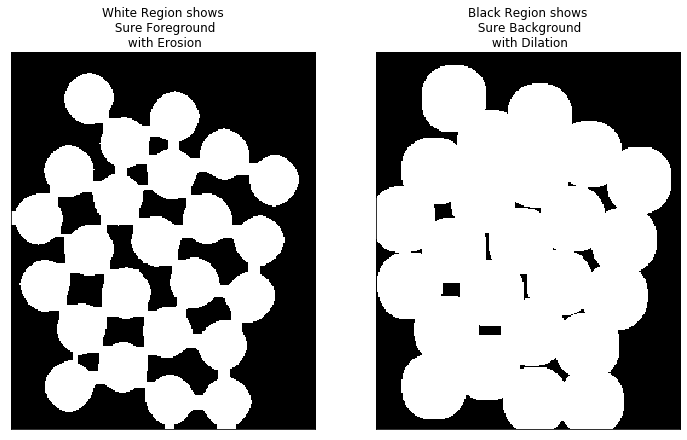

In [6]:
fig = plt.figure(figsize=(12, 8))

fig.add_subplot(1,2,1)
plt.imshow(erosion_fg, 'gray')
plt.title("White Region shows\n Sure Foreground\n with Erosion")
plt.xticks([]), plt.yticks([])

fig.add_subplot(1,2,2)
plt.imshow(sure_bg, 'gray')
plt.title("Black Region shows\n Sure Background\n with Dilation")
plt.xticks([]), plt.yticks([])

plt.show()

La solución al problema de que los objetos se estén tocando es aplicar la transformada de la distancia euclídea, es decir, para cada uno de los pixeles de foreground obtenemos la distancia euclídea al pixel de background más cercano, y finalmente aplicar un threshold (umbral) adecuado.

In [7]:
# Finding sure foreground area
dist_transform = cv2.distanceTransform(opening, cv2.DIST_L2, 5)
ret, sure_fg = cv2.threshold(dist_transform, 0.7 * dist_transform.max(), 255, 0)

# Finding unknown region
sure_fg = np.uint8(sure_fg)
unknown = cv2.subtract(sure_bg, sure_fg)

Muestro los resultados y el threshold de lo que concemnos que es seguro foreground.

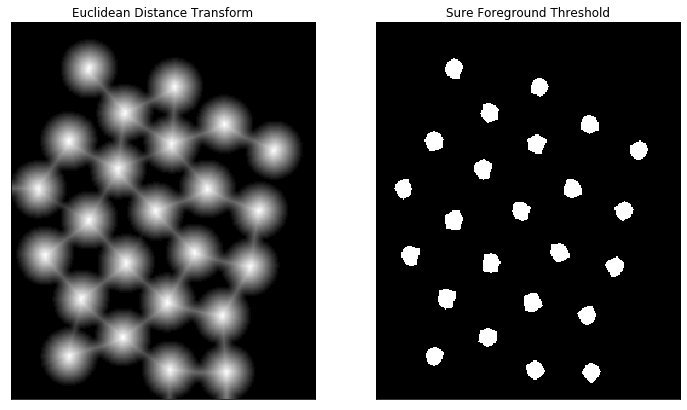

In [8]:
fig = plt.figure(figsize=(12, 8))

fig.add_subplot(1,2,1)
#plt.imshow(dist_transform, "jet_r")
plt.imshow(dist_transform, "gray")
plt.title("Euclidean Distance Transform")
plt.xticks([]), plt.yticks([])

fig.add_subplot(1,2,2)
plt.imshow(sure_fg, "gray")
plt.title("Sure Foreground Threshold")
plt.xticks([]), plt.yticks([])

plt.show()

Ahora que tengo definidas las regiones que seguro son background y foreground puedo crear el marcador, que es un array del mismo tamaño que la imagen original, y etiqueto las regiones dentro, las regiones que tengo claras son etiquetadas con cualquier número positivo, obviamente el número positivo usado para etiquetar el background deberá ser diferente al usado para etiquetar el foreground. El area que no se sabe con claridad se deja etiquetada como 0

In [9]:
# Marker labelling
#cv2.connectedComponents(). It labels background of the image with 0, then other objects are labelled with integers starting 
#from 1.
ret, markers = cv2.connectedComponents(sure_fg)

# Add one to all labels so that sure background is not 0, but 1, since 0 is the value for the unknown area
markers = markers + 1

# Now, mark the region of unknown with zero
markers[unknown == 255] = 0

Número de etiquetas diferentes en el marcador creado.

In [10]:
ret

25

Visualizo el marcador, que será la region `unknown`calculada antes, pero ahora cada elemento conctado incluyendo el area `unknown` tendrán un etiqueta distintiva. Esto permite que puedan ser mostrados con un mapa de color.

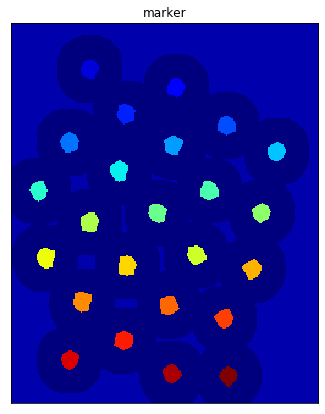

In [11]:
fig = plt.figure(figsize=(10, 7))

plt.imshow(markers, 'jet')
plt.title("marker")
plt.xticks([]), plt.yticks([])

plt.show()

Ahora finalmente aplico watershed a la imagen original usando el marcador. El marcador será actualizado aproximando el espacio de la región `unknown` que pertenece a background y la que pertenece a foreground, además los limites entre los objetos y el propio background les pondrá valor -1.

In [12]:
markers = cv2.watershed(img, markers)
# The boundaries of the marker will be mapped to the pixels of the original image and put in another color to highlight them.
imagen_aux = img.copy()
imagen_aux[markers == -1] = [0, 255, 0]

Muestro los resultados.

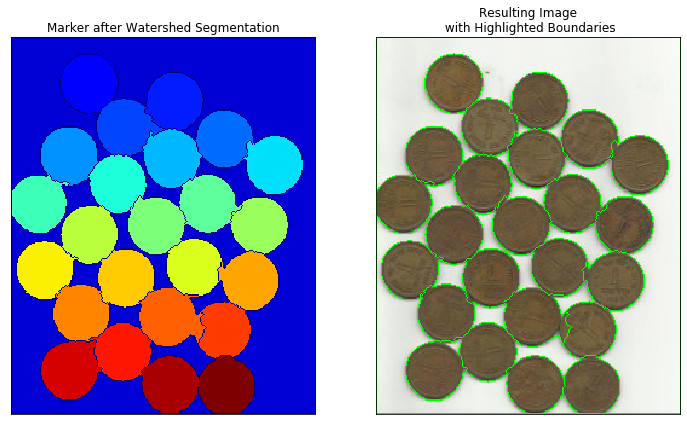

In [13]:
fig = plt.figure(figsize=(12, 8))

fig.add_subplot(1,2,1)
plt.imshow(markers, "jet")
plt.title("Marker after Watershed Segmentation")
plt.xticks([]), plt.yticks([])

fig.add_subplot(1,2,2)
plt.imshow(imagen_aux[...,::-1])  # RGB-> BGR
plt.title("Resulting Image\n with Highlighted Boundaries")
plt.xticks([]), plt.yticks([])

plt.show()

Con esto ya se puede contar el número de monedas de la imagen. Como cada etiqueta diferente del marcador es un elemento, simplemente al número total de etiquetas del marcador le restamos los dos elementos que están en el marcador y que sabemos que no hay que contar como monedas, el background (1) y los límites (-1).

In [14]:
n_objects_watershed = len(np.unique(markers)) - 2
n_objects_real = 24
error = (abs(n_objects_watershed - n_objects_real)/n_objects_real) * 100

print("Se han contado", n_objects_watershed, "monedas. La imagen contiene realmente", n_objects_real,
      "monedas, dando un error del", error, "%")

Se han contado 24 monedas. La imagen contiene realmente 24 monedas, dando un error del 0.0 %


Se puede usar el marcador para hacer una máscara en la que se seleccionen uno o varios objetos concretos de la imagen.

In [15]:
markers_mask = markers
#markers_mask[markers == 5] = [255, 0, 0]
markers_mask[markers != 5] = 0
imagen_aux = img.copy()
imagen_aux[markers == 5] = [0, 255, 0]

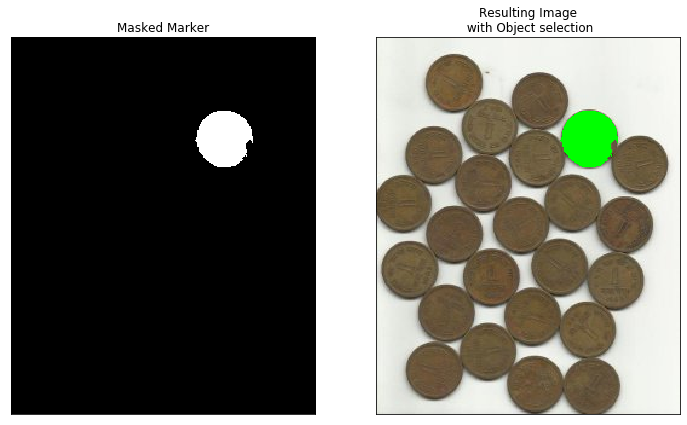

In [16]:
fig = plt.figure(figsize=(12, 8))

fig.add_subplot(1,2,1)
plt.imshow(markers, "gray")
plt.title("Masked Marker")
plt.xticks([]), plt.yticks([])

fig.add_subplot(1,2,2)
plt.imshow(imagen_aux[...,::-1])  # RGB-> BGR
plt.title("Resulting Image\n with Object selection")
plt.xticks([]), plt.yticks([])

plt.show()

### Con otra imagen de monedas diferente

Muestro la nueva imagen.

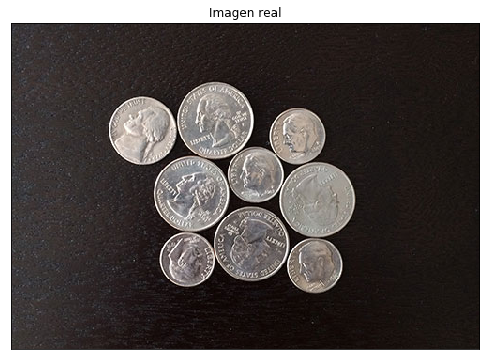

In [17]:
# Cargo la imagen de las monedas que se va ha procesar
img = cv2.imread('watershed_coins_02.jpg')

fig = plt.figure(figsize=(10, 6))
plt.imshow(img[...,::-1])  # RGB-> BGR
plt.title("Imagen real")
plt.xticks([]), plt.yticks([])

plt.show()

Se puede ver que el objeto que queremos procesar es más claro que el fondo, por lo que no hace falta sumarle el factor de inversión binario al threshold de Otsu.

In [18]:
gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
ret, thresh = cv2.threshold(gray, 0, 255, cv2.THRESH_OTSU)

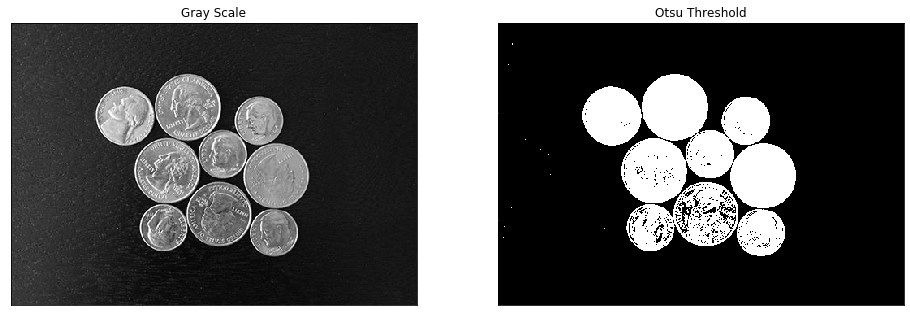

In [19]:
fig = plt.figure(figsize=(16, 10))

fig.add_subplot(1,2,1)
plt.imshow(gray, "gray")
plt.title("Gray Scale")
plt.xticks([]), plt.yticks([])

fig.add_subplot(1,2,2)
plt.imshow(thresh, "gray")
plt.title("Otsu Threshold")
plt.xticks([]), plt.yticks([])

plt.show()

Se puede ver que el threshold de Otsu ha tenido problemas para clasificar un par de monedas debido a sus detalles de la superficie. Se puede aplicar al inicio una filtración del desplazamiento medio llamado pyramid (pyramid mean shift filtering) que ayudará a mejorar la precisión del paso de threshold, basicamente alisa la superficie de la imagen.

In [20]:
shifted = cv2.pyrMeanShiftFiltering(img, 21, 51)
gray = cv2.cvtColor(shifted, cv2.COLOR_BGR2GRAY)
ret, thresh = cv2.threshold(gray, 0, 255, cv2.THRESH_OTSU)

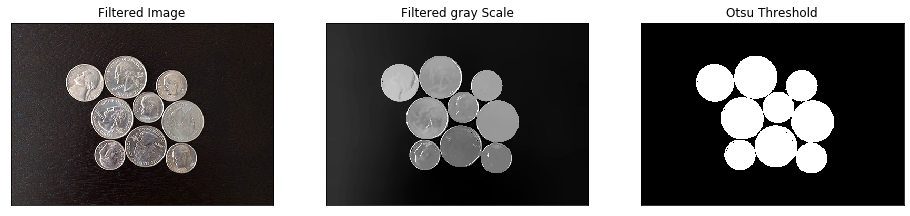

In [21]:
fig = plt.figure(figsize=(16, 10))
fig.add_subplot(1,3,1)
plt.imshow(img[...,::-1])  # RGB-> BGR
plt.title("Filtered Image")
plt.xticks([]), plt.yticks([])

fig.add_subplot(1,3,2)
plt.imshow(gray, "gray")
plt.title("Filtered gray Scale")
plt.xticks([]), plt.yticks([])

fig.add_subplot(1,3,3)
plt.imshow(thresh, "gray")
plt.title("Otsu Threshold")
plt.xticks([]), plt.yticks([])

plt.show()

Ahora igual que antes elimino el ruido blanco y trato los limites definiendo lo que seguro que es background y lo que seguro que es foreground.

Como las monedas se tocan usaré la tranformada de la distancia euclídea y no el método de erosión.

In [22]:
# noise removal
kernel = np.ones((3, 3), np.uint8)
opening = cv2.morphologyEx(thresh, cv2.MORPH_OPEN, kernel, iterations = 2)

# sure background area obtained with Dilation, this one will be used
sure_bg = cv2.dilate(opening, kernel, iterations = 3)

# Finding sure foreground area
dist_transform = cv2.distanceTransform(opening, cv2.DIST_L2, 5)
ret, sure_fg = cv2.threshold(dist_transform, 0.2 * dist_transform.max(), 255, 0)

# Finding unknown region
sure_fg = np.uint8(sure_fg)
unknown = cv2.subtract(sure_bg, sure_fg)

# Marker labelling
ret, markers = cv2.connectedComponents(sure_fg)

# Add one to all labels so that sure background is not 0, but 1, since 0 is the value for the unknown area
markers = markers + 1

# Now, mark the region of unknown with zero
markers[unknown == 255] = 0

markers = cv2.watershed(img, markers)
imagen_aux = img.copy()
imagen_aux[markers == -1] = [0, 255, 0]

Nota: Si a la hora de definir lo que se sabe seguro que es foreground a la máxima de la transformada de la distancia se le multiplica por un coeficiente alto como antes (0.7) va ha fallar una moneda por lo que pongo uno menor (0.2) y así acierta todas.

Muestro los resultados finales.

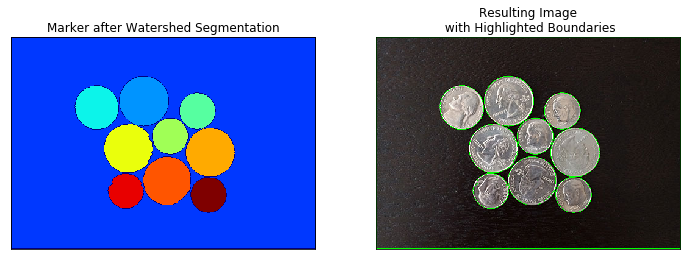

In [23]:
fig = plt.figure(figsize=(12, 8))

fig.add_subplot(1,2,1)
plt.imshow(markers, "jet")
plt.title("Marker after Watershed Segmentation")
plt.xticks([]), plt.yticks([])

fig.add_subplot(1,2,2)
plt.imshow(imagen_aux[...,::-1])  # RGB-> BGR
plt.title("Resulting Image\n with Highlighted Boundaries")
plt.xticks([]), plt.yticks([])

plt.show()

In [24]:
n_objects_watershed = len(np.unique(markers)) - 2
n_objects_real = 9
error = (abs(n_objects_watershed - n_objects_real)/n_objects_real) * 100

print("Se han contado", n_objects_watershed, "monedas. La imagen contiene realmente", n_objects_real,
      "monedas, dando un error del", error, "%")

Se han contado 9 monedas. La imagen contiene realmente 9 monedas, dando un error del 0.0 %


### Imagen de monedas superpuestas

Muestro la nueva imagen.

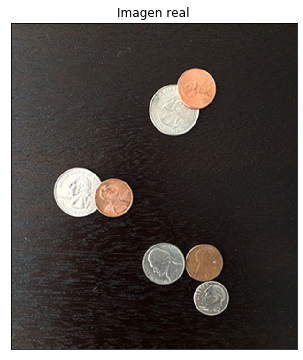

In [25]:
# Cargo la imagen de las monedas que se va ha procesar
img = cv2.imread('watershed_coins_03.png')

fig = plt.figure(figsize=(10, 6))
plt.imshow(img[...,::-1])  # RGB-> BGR
plt.title("Imagen real")
plt.xticks([]), plt.yticks([])

plt.show()

In [26]:
shifted = cv2.pyrMeanShiftFiltering(img, 21, 51)
gray = cv2.cvtColor(shifted, cv2.COLOR_BGR2GRAY)
ret, thresh = cv2.threshold(gray, 0, 255, cv2.THRESH_OTSU)

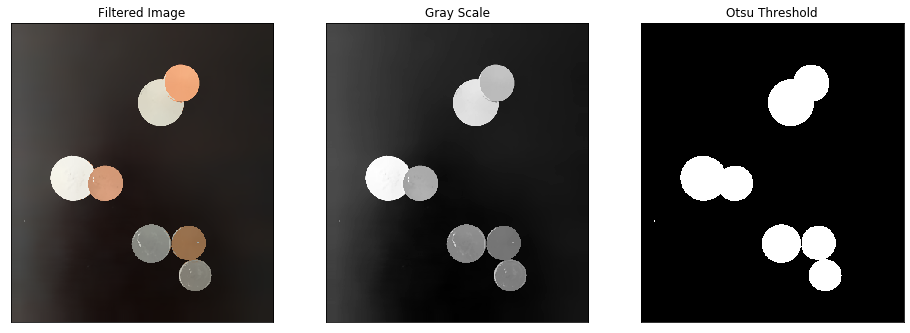

In [27]:
fig = plt.figure(figsize=(16, 10))
fig.add_subplot(1,3,1)
plt.imshow(shifted[...,::-1])  # RGB-> BGR
plt.title("Filtered Image")
plt.xticks([]), plt.yticks([])

fig.add_subplot(1,3,2)
plt.imshow(gray, "gray")
plt.title("Gray Scale")
plt.xticks([]), plt.yticks([])

fig.add_subplot(1,3,3)
plt.imshow(thresh, "gray")
plt.title("Otsu Threshold")
plt.xticks([]), plt.yticks([])

plt.show()

In [28]:
# noise removal
kernel = np.ones((3, 3), np.uint8)
opening = cv2.morphologyEx(thresh, cv2.MORPH_OPEN, kernel, iterations = 2)

# sure background area obtained with Dilation, this one will be used
sure_bg = cv2.dilate(opening, kernel, iterations = 3)

# Finding sure foreground area
dist_transform = cv2.distanceTransform(opening, cv2.DIST_L2, 5)
ret, sure_fg = cv2.threshold(dist_transform, 0.2 * dist_transform.max(), 255, 0)

# Finding unknown region
sure_fg = np.uint8(sure_fg)
unknown = cv2.subtract(sure_bg, sure_fg)

# Marker labelling
ret, markers = cv2.connectedComponents(sure_fg)

# Add one to all labels so that sure background is not 0, but 1, since 0 is the value for the unknown area
markers = markers + 1

# Now, mark the region of unknown with zero
markers[unknown == 255] = 0

markers = cv2.watershed(img, markers)
imagen_aux = img.copy()
imagen_aux[markers == -1] = [0, 255, 0]

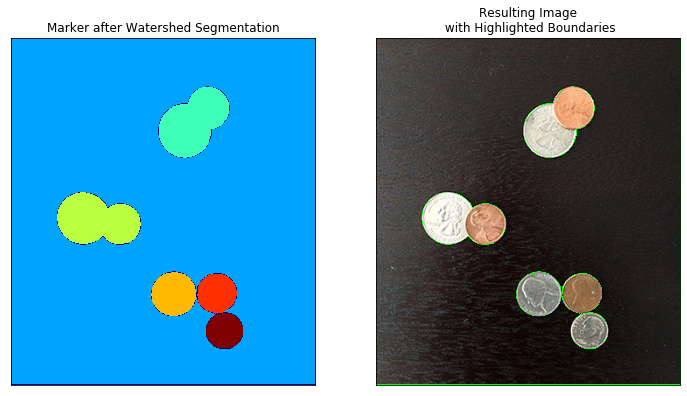

In [29]:
import imutils

fig = plt.figure(figsize=(12, 8))

fig.add_subplot(1,2,1)
plt.imshow(markers, "jet")
plt.title("Marker after Watershed Segmentation")
plt.xticks([]), plt.yticks([])

fig.add_subplot(1,2,2)
plt.imshow(imagen_aux[...,::-1])  # RGB-> BGR
plt.title("Resulting Image\n with Highlighted Boundaries")
plt.xticks([]), plt.yticks([])

plt.show()

In [30]:
n_objects_watershed = len(np.unique(markers)) - 2
n_objects_real = 7
error = (abs(n_objects_watershed - n_objects_real)/n_objects_real) * 100

print("Se han contado", n_objects_watershed, "monedas. La imagen contiene realmente", n_objects_real,
      "monedas, dando un error del", error, "%")

Se han contado 5 monedas. La imagen contiene realmente 7 monedas, dando un error del 28.57142857142857 %


No ha detectado las monedas superpuestas como diferentes objetos.

### Probarlo con una imagen de una bandada de aves

Muestro la nueva imagen, esta vez de una bandada de aves sobre un fondo azul homogeneo.

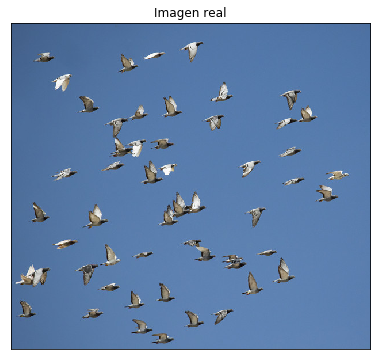

In [31]:
# Cargo la imagen de las aves que se va ha procesar
img = cv2.imread('Bandada_Aves.jpg')

fig = plt.figure(figsize=(10, 6))
plt.imshow(img[...,::-1])  # RGB-> BGR
plt.title("Imagen real")
plt.xticks([]), plt.yticks([])

plt.show()

In [32]:
shifted = cv2.pyrMeanShiftFiltering(img, 5, 31)
gray = cv2.cvtColor(shifted, cv2.COLOR_BGR2GRAY)
ret, thresh = cv2.threshold(gray, 0, 255, cv2.THRESH_OTSU)

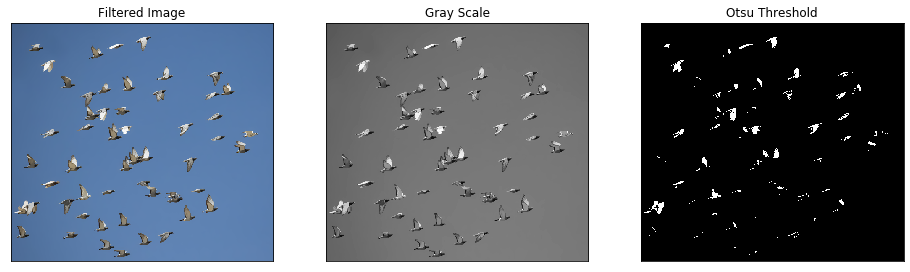

In [33]:
fig = plt.figure(figsize=(16, 10))

fig.add_subplot(1,3,1)
plt.imshow(shifted[...,::-1])  # RGB-> BGR
plt.title("Filtered Image")
plt.xticks([]), plt.yticks([])

fig.add_subplot(1,3,2)
plt.imshow(gray, "gray")
plt.title("Gray Scale")
plt.xticks([]), plt.yticks([])

fig.add_subplot(1,3,3)
plt.imshow(thresh, "gray")
plt.title("Otsu Threshold")
plt.xticks([]), plt.yticks([])

plt.show()

In [34]:
# noise removal
kernel = np.ones((3, 3), np.uint8)
opening = cv2.morphologyEx(thresh, cv2.MORPH_OPEN, kernel, iterations = 2)

# sure background area obtained with Dilation, this one will be used
sure_bg = cv2.dilate(opening, kernel, iterations = 5)

# Finding sure foreground area
dist_transform = cv2.distanceTransform(opening, cv2.DIST_L2, 5)
ret, sure_fg = cv2.threshold(dist_transform, 0.5 * dist_transform.max(), 255, 0)

# Finding unknown region
sure_fg = np.uint8(sure_fg)
unknown = cv2.subtract(sure_bg, sure_fg)

# Marker labelling
ret, markers = cv2.connectedComponents(sure_fg)

# Add one to all labels so that sure background is not 0, but 1, since 0 is the value for the unknown area
markers = markers + 1

# Now, mark the region of unknown with zero
markers[unknown == 255] = 0

markers = cv2.watershed(img, markers)
imagen_aux = img.copy()
imagen_aux[markers == -1] = [0, 255, 0]

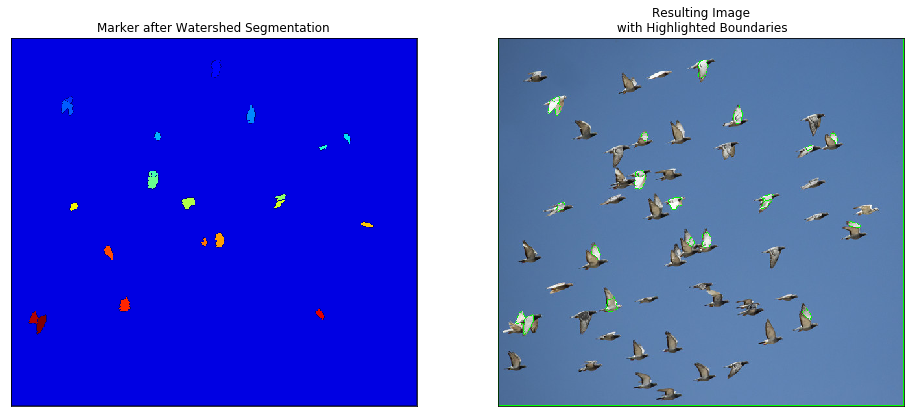

In [35]:
fig = plt.figure(figsize=(16, 10))

fig.add_subplot(1,2,1)
plt.imshow(markers, "jet")
plt.title("Marker after Watershed Segmentation")
plt.xticks([]), plt.yticks([])


fig.add_subplot(1,2,2)
plt.imshow(imagen_aux[...,::-1])  # RGB-> BGR
plt.title("Resulting Image\n with Highlighted Boundaries")
plt.xticks([]), plt.yticks([])

plt.show()

In [36]:
n_objects_watershed = len(np.unique(markers)) - 2
n_objects_real = 56
error = (abs(n_objects_watershed - n_objects_real)/n_objects_real) * 100

print("Se han contado", n_objects_watershed, "aves. La imagen contiene realmente", n_objects_real,
      "aves, dando un error del", error, "%")

Se han contado 21 aves. La imagen contiene realmente 56 aves, dando un error del 62.5 %


Las detecta bastante mal, el transformar la imagen a escala de grises hace que el threshold detecte el fondo azul y los tonos oscuros de algunos pajaros como si ambos fueran fondo.

### Prueba con la misma imagen de aves configurando las operaciones morfológicas y kernels para procesado de imagenes

Las transformaciones morfológicas son operaciones simples basadas en la forma de la imagen. Se realiza normalmente en imagenes binarias (como la binarización de Otsu que se aplica para realizar watershed). Necesita dos entradas, la imagen que se quiere procesar y el kernel o elemento estructurante (structuring element) que definirá la naturaleza de la operación. hasta ahora se han visto dos transformaciones morfológicas básicas como son la dilatación y la erosión (aunque se usaba la transformada de la distancia euclídea para identificar correctamente dos objetos cuyos bordes se tocan). Más información sobre transformaciones morfológicas:
- https://docs.opencv.org/trunk/d9/d61/tutorial_py_morphological_ops.html
- https://en.wikipedia.org/wiki/Mathematical_morphology

Para definir un kernel, primero hay que entender que una imagen se trata como una matriz de dos dimensiones de números, que se pueden entender como píxeles. Cada pixel (casilla de la matriz) es representado por un número, dependiendo del formato de la imagen esos números pueden variar, en este procesado de imagen yo haré transformaciones morfológicas que usarán kernels sobre imagenes en escala de grises (contra más claro sea el pixel más alto será su número correspondiente, y contra más oscuro más bajo), y sobre imagenes binarizadas (solo dos valores). Los kernels, elementos estructurantes o matrices convolucionales son arrays también de dos dimensiones (generalmente 3x3) que funcionan operando en los valores asociados a los pixels con operaciones aritméticas directas. En el siguiente ejemplo se muestra un kernel para difuminado de imagenes (blur),se centra el kernel sobre cada pixel de la imagen y se multiplican los valores de cada casilla del kernel sobre los valores que coincidan de los pixeles de la imagen centrada sobre el pixel que se quiere transformar, despues los valores resultantes de todas las multiplicaciones se suman y el valor resultante es el nuevo valor del pixel ya transformado.

$$\begin{pmatrix}
0.0625 & 0.125 & 0.0625 \\
0.125 & 0.25 & 0.125 \\
0.0625 & 0.125 & 0.0625 
\end{pmatrix}
x
\begin{pmatrix}
103 & 81 & 94 \\
83 & 85 & 88 \\
126 & 108 & 110 
\end{pmatrix}
=
\begin{pmatrix}
\underset{x0.0625}{103} & \underset{x0.125}{81} & \underset{x0.0625}{94} \\
\underset{x0.125}{83} & \underset{x0.25}{85} & \underset{x0.125}{88} \\
\underset{x0.0625}{126} & \underset{x0.125}{108} & \underset{x0.0625}{110} 
\end{pmatrix}
$$


$$=6.43+10.12+5.87+10.37+21.25+11+7.87+13.5+6.87=93$$

Páginas de interes sobre los kernels:
- https://www.naturefocused.com/articles/photography-image-processing-kernel.html
- https://en.wikipedia.org/wiki/Kernel_(image_processing)
- https://docs.gimp.org/2.8/en/plug-in-convmatrix.html
- https://setosa.io/ev/image-kernels/

Cargo la imagen de prueba de las aves de nuevo.

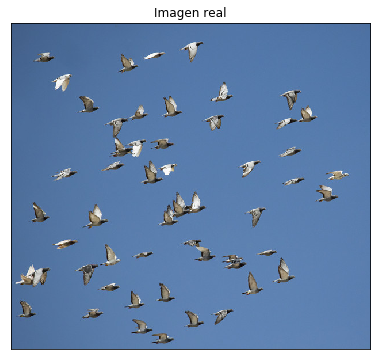

In [37]:
# Cargo la imagen de las aves que se va ha procesar
img = cv2.imread('Bandada_Aves.jpg')

fig = plt.figure(figsize=(10, 6))

plt.imshow(img[...,::-1])  # RGB-> BGR
plt.title("Imagen real")
plt.xticks([]), plt.yticks([])

plt.show()

Distintos tipos de kernel se pueden usar para operar y transformar pixeles, y realmente se puede crear un kernel y operar con él  con valores cualesquiera en la matriz, pero si se quiere conseguir un efecto concreto en la imagén se debe pensar cual usar. ya que no todas las combinaciones de valores producirán el mismo efecto en la imagen, por ejemplo, hay kernels ya conocidos y usados para difuminación de imagen, detección de bordes, acentuación de detalles, por nombrar algunos, a continuación muestro algunos de los más utilizados:

- Difuminado gausiano (gaussian blur): $\frac{1}{16} \begin{pmatrix} 1 & 2 & 1 \\ 2 & 4 & 2 \\ 1 & 2 & 1 \end{pmatrix}=\begin{pmatrix} 0.0625 & 0.125 & 0.0625 \\ 0.125 & 0.25 & 0.125 \\ 0.0625 & 0.125 & 0.0625 \end{pmatrix}$ ejemplo usado antes.


- Acentuación (sharpen): $\begin{pmatrix} 0 & -1 & 0 \\ -1 & 5 & -1 \\ 0 & -1 & 0 \end{pmatrix}$


- Detección de bordes (edge detection): $\begin{pmatrix} 1 & 0 & -1 \\ 0 & 0 & 0 \\ -1 & 0 & 1 \end{pmatrix}$


- Difuminado gausiano 5x5: $\frac{1}{256} \begin{pmatrix} 0 & 1 & 2 & 1 & 0 \\ 1 & 4 & 8 & 4 & 1 \\ 2 & 8 & 16 & 8 & 2 \\ 1 & 4 & 8 & 4 & 1 \\ 0 & 1 & 2 & 1 & 0 \end{pmatrix}$

Como se vio en la prueba anterior donde usaba las operaciones morfológicas estándar y un kernel que consistía en una matriz 3x3 de todo unos, no dió muy buenos resultados, realizaba un umbral de Otsu bastante ineficiente, en el que muchas zonas blancas (de pajaros) no se detectaban correctamente o se detectaban de manera miniscula por lo que se acaban perdiendo en el proceso de obtener el background y el foreground.

Para mejorar esto antes de realizar la binarización de Otsu preprocesaré la imagen original, como el problema estaba en que no terminaba de distingir el fondo por su tono azul oscuro que al pasar a escala de grises se confundia con el tono oscuro de los pajaros. La idea es que con la imagen preprocesada los pajaros cambién, se suavicen por ejemplo, pero el fondo al ser plano se mantendrá de manera similar, entonces si se lo resto a la imagen original como los fondos son practicamente iguales el valor del fondo de la imagen resultante será muy bajo, es decir será negro en la escala de colores y los pajaros al haberse diferenciado resaltarán más en la imagen, por lo que en la escala de grises el fondo será claramente nergo y los pajaros de un tono gris, pero con una gran diferenciación entre ambos.

Primero elijo un kernel,  en concreto el de difuminado gausiano.

In [38]:
# El método de tranformación morfológica de OpenCv parece que no admite 0 en sus valores de la matriz de kernel,
# por lo que pongo un valor muy bajo
kernel = np.matrix(([0.0000001, 1, 2, 1, 0.0000001], [1, 4, 8, 4, 1], [2, 8, 16, 8, 2], [1, 4, 8, 4, 1],
                    [0.0000001, 1, 2, 1, 0.0000001]))*(1/256)
kernel

matrix([[3.90625e-10, 3.90625e-03, 7.81250e-03, 3.90625e-03, 3.90625e-10],
        [3.90625e-03, 1.56250e-02, 3.12500e-02, 1.56250e-02, 3.90625e-03],
        [7.81250e-03, 3.12500e-02, 6.25000e-02, 3.12500e-02, 7.81250e-03],
        [3.90625e-03, 1.56250e-02, 3.12500e-02, 1.56250e-02, 3.90625e-03],
        [3.90625e-10, 3.90625e-03, 7.81250e-03, 3.90625e-03, 3.90625e-10]])

Aplico una tranformación morfológica `opening` con el kernel gausiano, lo que suiavizará la imagen de los pajaros, dejando el fondo prácticamente igual.

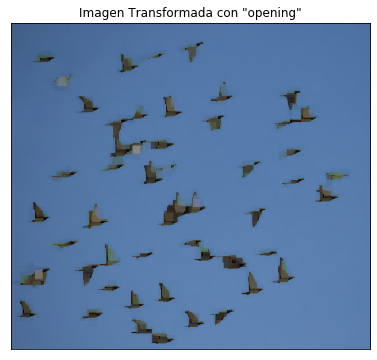

In [39]:
opening = cv2.morphologyEx(img, cv2.MORPH_OPEN, kernel, iterations = 3)

fig = plt.figure(figsize=(10, 6))

plt.imshow(opening[...,::-1])
plt.title('Imagen Transformada con "opening"')
plt.xticks([]), plt.yticks([])

plt.show()

Obtengo la diferencia entre la imagen original y la procesada, el fondo al ser prácticamente igual quedará con valores muy bajos (negro en la escala de colores) y como los pájaros (el foreground) sí que han sufrido una transformación significativa al hacer la diferencia si que resaltarán.

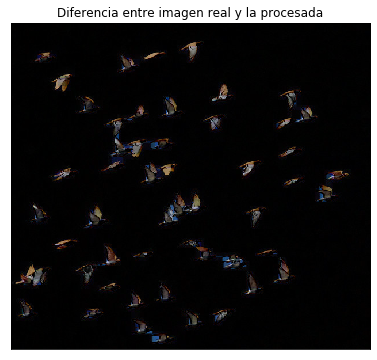

In [40]:
img_Proc = img - opening

fig = plt.figure(figsize=(10, 6))

plt.imshow(img_Proc[...,::-1])  # RGB-> BGR
plt.title("Diferencia entre imagen real y la procesada")
plt.xticks([]), plt.yticks([])

plt.show()

Entonces al aplicar la escala de grises sobre el resultado obtenido en el preprocesado habrá una mayor diferencia entre el background y el foreground, lo que se traducirá en umbral de Otsu más preciso.

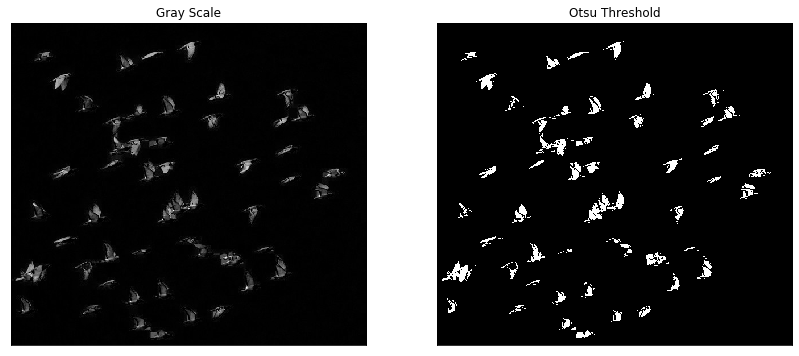

In [41]:
gray = cv2.cvtColor(img_Proc, cv2.COLOR_BGR2GRAY)
ret, thresh = cv2.threshold(gray, 0, 255, cv2.THRESH_OTSU)

fig = plt.figure(figsize=(14, 8))

fig.add_subplot(1,2,1)
plt.imshow(gray, "gray")
plt.title("Gray Scale")
plt.xticks([]), plt.yticks([])

fig.add_subplot(1,2,2)
plt.imshow(thresh, "gray")  # RGB-> BGR
plt.title("Otsu Threshold")
plt.xticks([]), plt.yticks([])

plt.show()

Se puede observar una clara mejoría en el threshold a la hora de diferenciar los pájaros del fondo habiendo procesado antes la imagen.

Anteriormente para aplicar las operaciones morfológicas y obtener el foreground y background solamente hacía un preprocesado `opening`, con un kernel simple de una matriz 3x3 de todo unos, está transformación morfológica consiste en aplicar erosión y luego dilatación consiguiendo con esto quitar ruido, pequeños puntos o suciedad que se ha detectado aplicando el umbral de Otsu pero que no tiene valor para lo que quiero detectar.

Esta vez, para obtener el foreground y background aplicaré un preprocesado un poco más complejo con la intención de mejorar el resultado final.

Ya se ha explicado lo que son las dos operaciones morfológicas básicas: `dilation` incrementar la zona detectada como foreground, `erosion` reducir la zona detectada como foreground, aunque se utilizaba la transformada de la distancia euclídea como alternativa debido a que simplemente la erosión no separaba correctamente distintos objetos que estuviesen colindando. Una transformación morfológica que voy a utilizar para el preprocesado de obtener el background es `closing`, basicamente es el contrario de la transformación `opening`, consiste en aplicar dilatación primero y después erosión, esto consigue eliminar el ruido e imperfecciones dentro de la figura detectada como foreground, y como se ve en la imagen obtenida del umbral de Otsu las figuras de los pajaros tienen bastantes imperfecciones. Por lo que primero se cerrarián las imperfecciones del foreground y después se dilataría para obtener lo que es seguro que es background. Para obtener el foreground aplicaré una combinación de dos transformaciones que se me ha ocurrido que puede funcionar bien, primero usaré la transformación morfológica `gradient`, que es la diferencia entre erosion y dilatación, obteniendo los bordes de la imagen de foreground, a continuación aplicando `closing` cierro los bordes obteniendo el foreground completo y por último haciendo la transformada de la distancia euclídea (el paso de erosión) se consigue lo que es seguro que es foreground.

In [42]:
# noise removal
closing = cv2.morphologyEx(thresh, cv2.MORPH_CLOSE, kernel, iterations = 5)
grad = cv2.morphologyEx(thresh, cv2.MORPH_GRADIENT, kernel, iterations = 1)
grad_close = cv2.morphologyEx(grad, cv2.MORPH_CLOSE, kernel, iterations = 2)

# sure background area obtained with Dilation, this one will be used
sure_bg = cv2.dilate(closing, kernel, iterations = 4)

# Finding sure foreground area
dist_transform = cv2.distanceTransform(grad_close, cv2.DIST_L2, 5)
ret, sure_fg = cv2.threshold(dist_transform, 0.25 * dist_transform.max(), 255, 0)

# Finding unknown region
sure_fg = np.uint8(sure_fg)
unknown = cv2.subtract(sure_bg, sure_fg)

# Marker labelling
ret, markers = cv2.connectedComponents(sure_fg)

# Add one to all labels so that sure background is not 0, but 1, since 0 is the value for the unknown area
markers = markers + 1

# Now, mark the region of unknown with zero
markers[unknown == 255] = 0

markers = cv2.watershed(img, markers)
imagen_aux = img.copy()
imagen_aux[markers == -1] = [0, 255, 0]

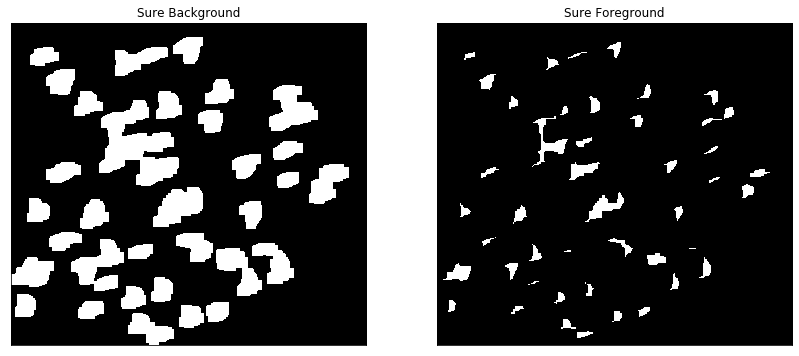

In [43]:
fig = plt.figure(figsize=(14, 8))

fig.add_subplot(1,2,1)
plt.imshow(sure_bg, "gray")
plt.title("Sure Background")
plt.xticks([]), plt.yticks([])


fig.add_subplot(1,2,2)
plt.imshow(sure_fg, "gray")
plt.title("Sure Foreground")
plt.xticks([]), plt.yticks([])

plt.show()

Una vez tengo lo que considero que es seguro que es background y foreground aplico el algoritmo de watershed.

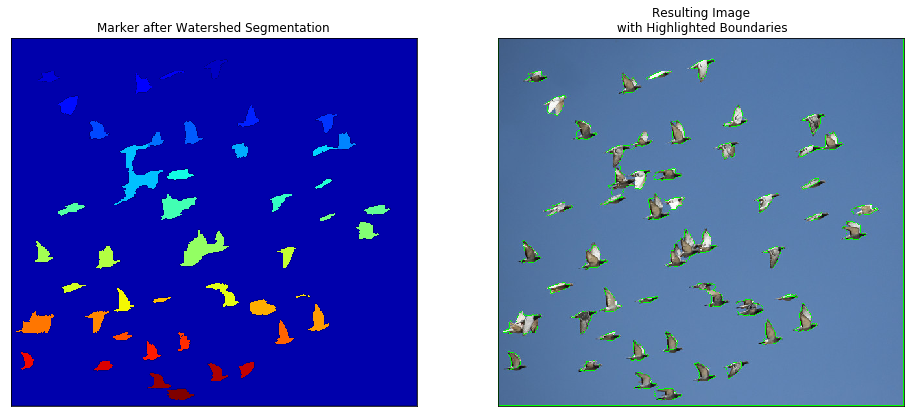

In [44]:
fig = plt.figure(figsize=(16, 10))

fig.add_subplot(1, 2, 1)
plt.imshow(markers, "jet")
plt.title("Marker after Watershed Segmentation")
plt.xticks([]), plt.yticks([])


fig.add_subplot(1, 2, 2)
plt.imshow(imagen_aux[...,::-1])  # RGB-> BGR
plt.title("Resulting Image\n with Highlighted Boundaries")
plt.xticks([]), plt.yticks([])

plt.show()

In [45]:
n_objects_watershed = len(np.unique(markers)) - 2
n_objects_real = 56
error = (abs(n_objects_watershed - n_objects_real)/n_objects_real) * 100

print("Se han contado", n_objects_watershed, "aves. La imagen contiene realmente", n_objects_real,
      "aves, dando un error del", error, "%")

Se han contado 49 aves. La imagen contiene realmente 56 aves, dando un error del 12.5 %


Se puede observar una clara mejoría, después de hacer un buen preprocesado a las imagenes, comparado a la anterior prueba, prácticamente ha detectado todo el foreground, aunque se haya arreglado el problema de la mala detección del foreground, sigue habiendo otro problema que tenía claro que no se iba a arreglar solo con el preprocesado, que es la superposición de los objetos. Aunque detecte correctamente la silueta de conjunto de pájaros seguirá estando mal si los detecta como un solo objeto y no consigue diferenciar entre cada pájaro. Además del mismo modo puede que se detecte alguna parte de un pájaro que este ligeremente separada del resto de la figura como otro objeto distinto.

Estos errores no parecen ser algo que se puedan solucionar con un algoritmo tan simple como watershed.

Esto es toda la parte de código que puedo subir a un repositorio público, dado que las pruebas con las aves del dataset del TFM se están utilizando para otra investigación y tienen un embargo.

## Conclusión watershed
El método watershed es una técnica que claramente empeora a grandes rasgos contra menos homogeneo sea el background y el foreground de la imagen a procesar, además de depender de la complejidad de la imagen en si, como cuantos elementos tiene el foreground. Para imagenes simples como unas monedas sobre un plano liso y homogeneo, o unos pájaros visibles y sobre un fondo diferenciable y homogeneo sirve bastante bien, además de ser rápido. Un problema importante que tiene es la superposición de elementos, puede detectar el foreground bien, pero a la hora de dividirlo en elementos tendrá problemas si estos están superpuestos y probablemente los tendrá en cuenta como un único elemento. Por lo demás no parece tener un buen rendimiento en imagenes con fondos complejos con muchos contrastes y además para que empiecen a dar buenos resultados estas imágenes con fondos complejos necesitan dedicarles un preprocesado costoso en tiempo, en el que hay que elegir cuidadosamente muchos parámetros, como el kernel, operaciones morfológicas a utilizar entte otros.

## Información de la sesión

In [76]:
import sys
sys.version

'3.7.3 (default, Apr 24 2019, 15:29:51) [MSC v.1915 64 bit (AMD64)]'

In [77]:
!pip freeze

absl-py==0.9.0
asn1crypto==1.3.0
astor==0.8.1
attrs==19.3.0
backcall==0.1.0
beautifulsoup4==4.8.2
bleach==3.1.0
blinker==1.4
bs4==0.0.1
cachetools==4.0.0
certifi==2020.4.5.2
cffi==1.14.0
cftime==1.1.1.1
chardet==3.0.4
click==7.1.1
colorama==0.4.3
conda==4.8.3
conda-package-handling==1.6.0
cryptography==2.8
cycler==0.10.0
decorator==4.4.2
defusedxml==0.6.0
entrypoints==0.3
Faker==3.0.0
gast==0.2.2
gastrodon==0.9.3
google-auth==1.11.2
google-auth-oauthlib==0.4.1
google-pasta==0.2.0
grpcio==1.27.2
h5py==2.10.0
idna==2.9
imageio==2.8.0
importlib-metadata==1.5.0
imutils==0.5.3
ipykernel==5.1.4
ipython==7.13.0
ipython-autotime==0.1
ipython-genutils==0.2.0
ipywidgets==7.5.1
isodate==0.6.0
jedi==0.16.0
Jinja2==2.11.1
joblib==0.14.1
jsonschema==3.2.0
jupyter==1.0.0
jupyter-client==6.1.0
jupyter-console==6.1.0
jupyter-core==4.6.1
kaggle==1.5.6
Keras==2.3.1
Keras-Applications==1.0.8
keras-contrib==2.0.8
Keras-Preprocessing==1.1.0
kiwisolver==1.1.0
lxml==4.5.0
Markdown==3.2.1
MarkupSafe==1.1.1
mat